In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lol-dataset/lol_dataset/eval15/low/780.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/778.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/493.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/669.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/547.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/55.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/1.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/748.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/22.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/146.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/179.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/665.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/23.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/111.png
/kaggle/input/lol-dataset/lol_dataset/eval15/low/79.png
/kaggle/input/lol-dataset/lol_dataset/eval15/high/780.png
/kaggle/input/lol-dataset/lol_dataset/eval15/high/778.png
/kaggle/input/lol-dataset/lol_datas

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import optuna
import numpy as np
from tqdm import tqdm
from torchvision import models 
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
from PIL import Image
import kagglehub
import cv2
import glob
import time
import kornia.color as color
import matplotlib.pyplot as plt

In [3]:
class LowLightDataset(Dataset):
    def __init__(self, root_dir_low, root_dir_high, transform=None, is_training=False, patch_size=128):
        """
        Khởi tạo dataset cho ảnh thiếu sáng và ảnh độ sáng cao.

        Args:
            root_dir_low (str): Đường dẫn đến thư mục chứa ảnh low-light.
            root_dir_high (str): Đường dẫn đến thư mục chứa ảnh high-light (ground truth).
            transform (callable, optional): Các biến đổi ảnh. Defaults to None.
            is_training (bool, optional): Có phải là train dataset hay không. Defaults to False.
            patch_size (int, optional): Kích thước patch ảnh. Defaults to 128.
        """
        self.root_dir_low = root_dir_low
        self.root_dir_high = root_dir_high
        self.transform = transform
        self.low_image_paths = []
        self.high_image_paths = []

        # Tìm ảnh low-light
        for ext in ('*.png', '*.jpg', '*.jpeg'):
            self.low_image_paths.extend(glob.glob(os.path.join(root_dir_low, '**', ext), recursive=True))

        # Tìm ảnh high-light (giả sử tên file tương ứng)
        self.high_image_paths = [os.path.join(root_dir_high, os.path.basename(path)) for path in self.low_image_paths]

        # Kiểm tra xem số lượng ảnh có khớp nhau không
        assert len(self.low_image_paths) == len(self.high_image_paths), "Số lượng ảnh low-light và high-light không khớp."

        self.is_training = is_training
        self.patch_size = patch_size

    def __len__(self):
        return len(self.low_image_paths)

    def __getitem__(self, idx):
        low_image_path = self.low_image_paths[idx]
        high_image_path = self.high_image_paths[idx]

        # Đọc ảnh low-light
        low_image = Image.open(low_image_path).convert("RGB")
        low_image = np.array(low_image, dtype=np.float32) / 255.0

        # Đọc ảnh high-light
        high_image = Image.open(high_image_path).convert("RGB")
        high_image = np.array(high_image, dtype=np.float32) / 255.0
        
        # Tạo patch từ ảnh
        h, w, _ = low_image.shape
        x = np.random.randint(0, h - self.patch_size) if self.is_training else 0
        y = np.random.randint(0, w - self.patch_size) if self.is_training else 0

        low_image_patch = low_image[x: x + self.patch_size, y: y + self.patch_size, :]
        high_image_patch = high_image[x: x + self.patch_size, y: y + self.patch_size, :]

        # Chuyển đổi thành tensor: shape (3, patch_size, patch_size)
        low_image_tensor = torch.tensor(low_image_patch, dtype=torch.float32).permute(2, 0, 1)
        high_image_tensor = torch.tensor(high_image_patch, dtype=torch.float32).permute(2, 0, 1)

        # Tính toán histogram equalization cho kênh max
        max_channel = torch.max(low_image_tensor, dim=0, keepdim=True)[0]  # shape (1, patch_size, patch_size)
        max_channel_np = (max_channel.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
        equalized_np = cv2.equalizeHist(max_channel_np)
        input_low_eq = torch.tensor(equalized_np, dtype=torch.float32) / 255.0
        input_low_eq = input_low_eq.unsqueeze(0)  # shape (1, patch_size, patch_size)

        # Data augmentation cho training (nếu cần)
        if self.is_training:
            rand_mode = np.random.randint(0, 7)
            low_image_tensor = data_augmentation(low_image_tensor, rand_mode)
            high_image_tensor = data_augmentation(high_image_tensor, rand_mode)

        # Trả về 4 giá trị: low-light image, high-light image, và ảnh đã cân bằng histogram
        return low_image_tensor, high_image_tensor, input_low_eq
        
def data_augmentation(img, rand_mode):
    """
    Áp dụng data augmentation cho ảnh.

    Args:
        img (torch.Tensor): Tensor ảnh có shape (C, H, W) với giá trị pixel được chuẩn hóa (thường nằm trong khoảng [0, 1]).
        rand_mode (int): Chọn kiểu biến đổi từ 0 đến 12.
        
    Returns:
        torch.Tensor: Ảnh đã biến đổi với shape (C, H, W).
    """
    # Chuyển từ tensor sang numpy array với shape (H, W, C)
    img_np = img.permute(1, 2, 0).cpu().numpy()
    
    if rand_mode == 0:
        # Không biến đổi
        out = img_np
    elif rand_mode == 1:
        # Lật ngang
        out = np.fliplr(img_np)
    elif rand_mode == 2:
        # Lật dọc
        out = np.flipud(img_np)
    elif rand_mode == 3:
        # Chuyển vị (transpose)
        out = np.transpose(img_np, (1, 0, 2))
    elif rand_mode == 4:
        # Transpose rồi lật ngang
        out = np.fliplr(np.transpose(img_np, (1, 0, 2)))
    elif rand_mode == 5:
        # Transpose rồi lật dọc
        out = np.flipud(np.transpose(img_np, (1, 0, 2)))
    elif rand_mode == 6:
        # Xoay 90 độ
        out = np.rot90(img_np, k=1)
    elif rand_mode == 7:
        # Xoay 180 độ
        out = np.rot90(img_np, k=2)
    elif rand_mode == 8:
        # Xoay 270 độ
        out = np.rot90(img_np, k=3)
    elif rand_mode == 9:
        # Tăng độ sáng: nhân với hệ số >1, sau đó clip về [0,1]
        out = np.clip(img_np * 1.2, 0, 1)
    elif rand_mode == 10:
        # Thêm nhiễu Gaussian
        noise = np.random.normal(0, 0.05, img_np.shape)
        out = np.clip(img_np + noise, 0, 1)
    else:
        out = img_np

    # Đảm bảo mảng có bộ nhớ liên tục
    out = np.ascontiguousarray(out)
    
    # Chuyển về tensor và điều chỉnh shape về (C, H, W)
    out_tensor = torch.tensor(out, dtype=torch.float32).permute(2, 0, 1)
    return out_tensor

In [4]:
def rgb_to_grayscale(img):
    """
    Chuyển ảnh RGB (shape: (N, 3, H, W)) sang grayscale (shape: (N, 1, H, W))
    Công thức: Y = 0.2989*R + 0.5870*G + 0.1140*B
    """
    return 0.2989 * img[:, 0:1, :, :] + 0.5870 * img[:, 1:2, :, :] + 0.1140 * img[:, 2:3, :, :]

def gradient_x(img):
    """
    Tính gradient theo chiều x (width)
    """
    return img[:, :, :, 1:] - img[:, :, :, :-1]

def gradient_y(img):
    """
    Tính gradient theo chiều y (height)
    """
    return img[:, :, 1:, :] - img[:, :, :-1, :]

def smooth_loss(I, R):
    """
    Tính loss làm mượt cho thành phần ánh sáng I dựa trên gradient của thành phần phản xạ R.
    Ví dụ: loss = mean(|grad(I)| * exp(-|grad(R_gray)|))
    """
    R_gray = rgb_to_grayscale(R)  # Chuyển R sang grayscale (N,1,H,W)
    grad_I_x = gradient_x(I)
    grad_I_y = gradient_y(I)
    grad_R_x = gradient_x(R_gray)
    grad_R_y = gradient_y(R_gray)
    
    weight_x = torch.exp(-10 * torch.abs(grad_R_x))  # Tăng alpha để làm mịn mạnh hơn
    weight_y = torch.exp(-10 * torch.abs(grad_R_y))
    
    loss_x = torch.mean(torch.abs(grad_I_x) * weight_x)
    loss_y = torch.mean(torch.abs(grad_I_y) * weight_y)
    
    return loss_x + loss_y

In [5]:
def bilateral_filter(input, d, sigma_color, sigma_space):
    """
    Áp dụng Bilateral Filter cho ảnh input.
    
    Args:
        input (Tensor): Ảnh đầu vào có kích thước [B, C, H, W] (có thể là ảnh grayscale hoặc RGB).
        d (int): Kích thước của kernel (nên là số lẻ, ví dụ 5).
        sigma_color (float): Giá trị sigma cho khoảng cách cường độ (range).
        sigma_space (float): Giá trị sigma cho khoảng cách không gian.
    
    Returns:
        Tensor: Ảnh sau khi áp dụng Bilateral Filter, kích thước [B, C, H, W].
    """
    B, C, H, W = input.shape
    pad = d // 2
    # Padding ảnh (sử dụng mode 'reflect' để tránh biên)
    padded = F.pad(input, (pad, pad, pad, pad), mode='reflect')
    
    # Sử dụng unfold để lấy các patch có kích thước d x d cho mỗi vị trí ảnh
    # patches có kích thước [B, C*d*d, H*W]
    patches = F.unfold(padded, kernel_size=d)
    # Reshape về kích thước [B, C, d*d, H, W]
    patches = patches.view(B, C, d*d, H, W)
    
    # Lấy điểm trung tâm của mỗi patch (giả sử d là số lẻ)
    center_index = (d*d) // 2
    center_pixel = patches[:, :, center_index, :, :].unsqueeze(2)  # [B, C, 1, H, W]
    
    # Tính trọng số không gian (spatial kernel)
    x_coord = torch.arange(d, dtype=torch.float32, device=input.device)
    y_coord = torch.arange(d, dtype=torch.float32, device=input.device)
    x_grid, y_grid = torch.meshgrid(x_coord, y_coord, indexing='ij')
    center = d // 2
    spatial_kernel = torch.exp(-((x_grid - center)**2 + (y_grid - center)**2) / (2 * sigma_space**2))
    # Reshape về [1, 1, d*d, 1, 1] để có thể broadcast
    spatial_kernel = spatial_kernel.reshape(1, 1, d*d, 1, 1)
    
    # Tính trọng số cường độ (range kernel)
    range_kernel = torch.exp(-((patches - center_pixel)**2) / (2 * sigma_color**2))
    
    # Tổng hợp trọng số
    weights = spatial_kernel * range_kernel  # [B, C, d*d, H, W]
    norm_factor = weights.sum(dim=2, keepdim=True)
    
    # Tính ảnh đã được làm mượt: weighted average của các pixel trong patch
    filtered = (weights * patches).sum(dim=2, keepdim=True) / norm_factor
    filtered = filtered.squeeze(2)  # Kết quả có kích thước [B, C, H, W]
    
    return filtered

def bilateral_loss(pred, d=5, sigma_color=0.1, sigma_space=3):
    """
    Hàm loss dựa trên Bilateral Filter.
    
    Loss được tính là sai lệch trung bình (L1) giữa ảnh dự đoán và ảnh đã được Bilateral Filter.
    Mục đích là khuyến khích ảnh dự đoán có tính mượt mà (loại bỏ nhiễu) trong khi vẫn bảo toàn các cạnh quan trọng.
    
    Args:
        pred (Tensor): Ảnh dự đoán, kích thước [B, C, H, W].
        d (int): Kích thước của kernel Bilateral Filter.
        sigma_color (float): Giá trị sigma cho khoảng cách cường độ.
        sigma_space (float): Giá trị sigma cho khoảng cách không gian.
    
    Returns:
        Tensor: Giá trị loss (scalar).
    """
    filtered = bilateral_filter(pred, d, sigma_color, sigma_space)
    loss = torch.mean(torch.abs(pred - filtered))
    return loss

In [6]:
def center_crop(tensor, target_height, target_width):
    """
    Cắt trung tâm tensor về kích thước (target_height, target_width)
    tensor có shape [N, C, H, W]
    """
    _, _, h, w = tensor.shape
    start_h = (h - target_height) // 2
    start_w = (w - target_width) // 2
    return tensor[:, :, start_h:start_h + target_height, start_w:start_w + target_width]

In [7]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        """
        channels: Số kênh của đầu vào
        reduction: Hệ số giảm kênh trong giai đoạn squeeze (mặc định 16)
        """
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: thu gọn đặc trưng theo chiều không gian
        y = self.avg_pool(x).view(b, c)
        # Excitation: tính trọng số cho từng kênh
        y = self.fc(y).view(b, c, 1, 1)
        # Scale: nhân các trọng số này với đầu vào
        return x * y
        
class ResUnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        """
        in_channels: số kênh đầu vào
        out_channels: số kênh đầu ra
        stride: stride của conv đầu tiên (mặc định 1)
        reduction: hệ số giảm cho SEBlock
        """
        super(ResUnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.se = SEBlock(out_channels, reduction)
        
        # Shortcut connection: nếu kích thước khác nhau, điều chỉnh bằng conv 1x1
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        
        out += identity
        out = self.relu(out)
        return out

In [8]:
class DecomUnet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(DecomUnet, self).__init__()
        self.input_max = 0
        # -----------------------
        # Encoder
        # -----------------------
        self.enc1 = ResUnetBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = ResUnetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = ResUnetBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = ResUnetBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ResUnetBlock(512, 1024)
        
        # -----------------------
        # Decoder chung (gộp cho cả 2 nhánh)
        # -----------------------
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ResUnetBlock(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResUnetBlock(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResUnetBlock(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResUnetBlock(128, 64)
        
        # -----------------------
        # Head đầu ra duy nhất với số kênh = 4
        # -----------------------
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Tính giá trị cực đại của input và ghép vào kênh đầu vào
        self.input_max = torch.amax(x, dim=1, keepdim=True)
        x = torch.cat([self.input_max, x], dim=1)
        
        # -----------------------
        # Encoder
        # -----------------------
        e1 = self.enc1(x)         # (N, 64, H, W)
        p1 = self.pool1(e1)       # (N, 64, H/2, W/2)
        
        e2 = self.enc2(p1)        # (N, 128, H/2, W/2)
        p2 = self.pool2(e2)       # (N, 128, H/4, W/4)
        
        e3 = self.enc3(p2)        # (N, 256, H/4, W/4)
        p3 = self.pool3(e3)       # (N, 256, H/8, W/8)
        
        e4 = self.enc4(p3)        # (N, 512, H/8, W/8)
        p4 = self.pool4(e4)       # (N, 512, H/16, W/16)
        
        # Bottleneck
        b = self.bottleneck(p4)   # (N, 1024, H/16, W/16)
        
        # -----------------------
        # Decoder chung
        # -----------------------
        d4 = self.up4(b)                           # (N, 512, H/8, W/8)
        e4_crop = center_crop(e4, d4.size(2), d4.size(3))
        d4 = torch.cat([d4, e4_crop], dim=1)         # (N, 1024, H/8, W/8)
        d4 = self.dec4(d4)                           # (N, 512, H/8, W/8)
        
        d3 = self.up3(d4)                           # (N, 256, H/4, W/4)
        e3_crop = center_crop(e3, d3.size(2), d3.size(3))
        d3 = torch.cat([d3, e3_crop], dim=1)         # (N, 512, H/4, W/4)
        d3 = self.dec3(d3)                           # (N, 256, H/4, W/4)
        
        d2 = self.up2(d3)                           # (N, 128, H/2, W/2)
        e2_crop = center_crop(e2, d2.size(2), d2.size(3))
        d2 = torch.cat([d2, e2_crop], dim=1)         # (N, 256, H/2, W/2)
        d2 = self.dec2(d2)                           # (N, 128, H/2, W/2)
        
        d1 = self.up1(d2)                           # (N, 64, H, W)
        e1_crop = center_crop(e1, d1.size(2), d1.size(3))
        d1 = torch.cat([d1, e1_crop], dim=1)         # (N, 128, H, W)
        d1 = self.dec1(d1)                           # (N, 64, H, W)
        
        # -----------------------
        # Đầu ra duy nhất với 4 kênh
        # -----------------------
        R = torch.sigmoid(d1[:, 0:3, :, :])
        I = torch.sigmoid(d1[:, 3:4, :, :])

        return R, I

In [9]:
class LowlightEnhance(nn.Module):
    def __init__(self, channel=64, kernel_size=3, lambda_recon=1.1, lambda_smooth_i=0.3, lambda_eq=0.1, lambda_smooth_r=0.3, lambda_exposure=0.3):
        """
           Tạo mô hình DecomNet.
        """
        super(LowlightEnhance, self).__init__()

        self.decom_net = DecomUnet()
        self.conv_gx = nn.Conv2d(1, 1, kernel_size=(1,2), padding=1, bias=False)
        self.conv_gy = nn.Conv2d(1, 1, kernel_size=(2,1), padding=1, bias=False)

        # Initialize conv_gx and conv_gy with predefined kernels
        self.conv_gx.weight = nn.Parameter(torch.tensor([[[[0.0, 0.0],[-1.0, 1.0]]]], dtype=torch.float32, requires_grad=False))
        self.conv_gy.weight = nn.Parameter(torch.tensor([[[[0.0], [-1.0]]]], dtype=torch.float32, requires_grad=False))

        self.lambda_recon = lambda_recon
        self.lambda_smooth_i = lambda_smooth_i
        self.lambda_eq = lambda_eq
        self.lambda_smooth_r = lambda_smooth_r
        self.lambda_exposure = lambda_exposure
        
    def forward(self, input_low, input_high):
        """
        input_low: tensor ảnh low-light, shape (N, 3, H, W)
        Trả về:
          - R_low: thành phần phản xạ, shape (N, 3, H, W)
          - I_low_3: thành phần ánh sáng (sau khi nhân bản 3 kênh), shape (N, 3, H, W)
          - S_low_zy: ảnh tái tạo = R_low * I_low_3
        """
        R_high, I_high = self.decom_net(input_high)
        R_low, I_low = self.decom_net(input_low)  # I_low có shape (N, 1, H, W)
        I_low_3 = torch.cat([I_low, I_low, I_low], dim=1)  # nhân bản từ 1 kênh thành 3 kênh
        return R_low, I_low_3, R_high, I_high 
    
    def compute_loss(self, input_low, input_high, input_low_eq):
        """
        Tính các thành phần loss như sau:
          1. recon_loss_low: L1 loss giữa (R_low * I_low_3) và input_high (giữ màu và giảm nhiễu)
          2. recon_loss_low_eq: L1 loss giữa max(R_low) theo channel và input_low_eq (cải thiện độ tương phản)
          3. R_low_loss_smooth: loss làm mượt cho R_low dựa trên gradient (giảm nhiễu)
          4. Ismooth_loss_low: loss làm mượt cho thành phần ánh sáng I_low (smooth loss)
        
        Trả về:
          - loss tổng hợp (loss_Decom_zhang_yu)
          - Các thành phần loss riêng lẻ (nếu cần để debug)
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Forward pass
        R_low, I_low_3, R_high, I_high = self.forward(input_low, input_high)
        
        # 1. Reconstruction loss
        recon_loss_low = torch.mean(torch.abs(R_low * I_low_3 - input_high))

        I_high_3 = torch.cat([I_high, I_high, I_high], dim=1)
        recon_loss_high = torch.mean(torch.abs(R_high * I_high_3 - input_high))

        # 2. Histogram Equalization Loss: Lấy giá trị max theo channel (dim=1) của R_low
        R_low_max, _ = torch.max(R_low, dim=1, keepdim=True)  # (N,1,H,W)
        recon_loss_low_eq = torch.mean(torch.abs(R_low_max - input_low_eq))
        
        # 3. Smooth loss cho R_low: chuyển sang grayscale và tính gradient
        R_low_gray = rgb_to_grayscale(R_low)
        # grad_x = F.conv2d(R_low_gray, self.conv_gx.weight.data, padding=1)
        # grad_y = F.conv2d(R_low_gray, self.conv_gy.weight.data, padding=1)
        # loss_x = torch.mean(torch.abs(grad_x))
        # loss_y = torch.mean(torch.abs(grad_y))
        R_low_loss_smooth = bilateral_loss(R_low_gray)
  
        # 4. Smooth loss cho thành phần ánh sáng: sử dụng hàm smooth_loss
        # Vì I_low ban đầu có 1 kênh, ta lấy một kênh từ I_low_3
        I_low = I_low_3[:, :1, :, :]
        Ismooth_loss_low = smooth_loss(I_low, R_low)

        # 5. Exposure Loss
        mean_intensity = torch.mean(R_low * I_low_3)
        Exposure_loss = torch.abs(mean_intensity - 0.7)

        i_consistency_loss = torch.mean(torch.abs(I_low - I_high)**2)
        r_consistency_loss = torch.mean(torch.abs(R_low - R_high))
        
        # Tổng hợp loss (theo hệ số đã cho)
        loss_Decom_zhangyu = (self.lambda_recon * recon_loss_low + 
                              self.lambda_smooth_i * Ismooth_loss_low +
                              self.lambda_eq * recon_loss_low_eq +
                              self.lambda_smooth_r * R_low_loss_smooth + 
                              self.lambda_exposure * Exposure_loss +
                              0.5 * i_consistency_loss + 0.1 * i_consistency_loss)
        
        return loss_Decom_zhangyu, recon_loss_low, recon_loss_low_eq, R_low_loss_smooth, Ismooth_loss_low, Exposure_loss

    def gradient(self, input_tensor, direction):
        """
        Tính gradient của tensor đầu vào theo hướng x hoặc y.
        """
        # Kernel gradient theo chiều x
        smooth_kernel_x = torch.FloatTensor([[0, 0], [-1, 1]]).view((1, 1, 2, 2))
        
        # Kernel gradient theo chiều y (hoán vị kernel x)
        smooth_kernel_y = torch.transpose(self.smooth_kernel_x, 2, 3)
        
        if direction == "x":
            kernel = smooth_kernel_x.to(input_tensor.device)  # Đưa kernel về đúng device của input
        elif direction == "y":
            kernel = smooth_kernel_y.to(input_tensor.device)
        else:
            raise ValueError("Direction must be 'x' or 'y'")

        # Áp dụng convolution để tính gradient
        grad = F.conv2d(input_tensor, kernel, stride=1, padding=1)
        
        # Trả về giá trị tuyệt đối của gradient
        return torch.abs(grad)

    def load(self, ckpt_dir):
        #Tạo một hàm load để load model
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        files = os.listdir(ckpt_dir)
        model_name = "None"
        for f in files:
            if ".pth" in f:
                model_name = f
        full_path = os.path.join(ckpt_dir,model_name)

        if os.path.exists(full_path):
            checkpoint = torch.load(full_path)
            model.decom_net.load_state_dict(checkpoint['model_state_dict'])
            iter_num = checkpoint['iter']
            print(f"[*] Load weights successfully,model_name:{model_name}...")

            return True,iter_num
        else:
            print("[*] Failed to load model from %s" % ckpt_dir)
            return False, 0

    def save(self, iter_num, ckpt_dir, model_name):
        #Tạo một hàm save để lưu model
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        print("[*] Saving model %s" % model_name)
        torch.save({
            'iter': iter_num,
            'model_state_dict': model.decom_net.state_dict(),
        }, os.path.join(ckpt_dir, model_name + '.pth'))

    def train_model(self, train_loader, batch_size, epoch, lr, sample_dir, ckpt_dir, eval_every_epoch, train_phase, device, val_loader=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        numBatch = len(train_loader)
        optimizer = optim.Adam(self.decom_net.parameters(), lr=2e-3)
        
        # Khởi tạo biến để quản lý việc load model
        start_epoch = 0
        load_model_status, global_step = self.load(ckpt_dir)
        if load_model_status:
            iter_num = global_step
            start_epoch = global_step // numBatch
            start_step = global_step % numBatch
            print("[*] Model restore success!")
        else:
            iter_num = 0
            start_epoch = 0
            start_step = 0
            print("[*] Not find pretrained model!")
            
        if not os.path.exists(sample_dir):
            os.makedirs(sample_dir)
        print("[*] Start training for phase %s, with start epoch %d, start iter %d:" % (train_phase, start_epoch, iter_num))
        
        start_time = time.time()
        self.decom_net.train()  # Đưa DecomNet vào chế độ huấn luyện
        
        # Vòng lặp qua các epoch
        for epoch_idx in range(start_epoch, epoch):
            epoch_loss = 0.0
            epoch_recon_low = 0.0
            epoch_recon_eq = 0.0
            # Sử dụng tqdm để hiển thị thanh tiến trình cho toàn bộ epoch
            pbar = tqdm(train_loader, desc=f"Epoch {epoch_idx+1}/{epoch}", leave=False)
            for batch_idx, (input_low, input_high, input_low_eq) in enumerate(pbar):
                input_low = input_low.to(device)
                input_high = input_high.to(device)
                input_low_eq = input_low_eq.to(device)
        
                optimizer.zero_grad()
        
                # Gọi hàm compute_loss của model
                loss, recon_loss_low, recon_loss_low_eq, R_low_loss_smooth, Ismooth_loss_low, Exposure_loss = self.compute_loss(input_low, input_high, input_low_eq)
        
                loss.backward()
                optimizer.step()

                epoch_recon_low += recon_loss_low.item()
                epoch_recon_eq += recon_loss_low_eq.item()  
                epoch_loss += loss.item()
                iter_num += 1
                
                # Cập nhật thông tin trên thanh tiến trình (tùy chọn)
                pbar.set_postfix({"batch_loss": loss.item()})
            
            avg_epoch_loss_recon_low = epoch_recon_low / numBatch
            avg_epoch_recon_eq = epoch_recon_eq / numBatch
            avg_epoch_loss = epoch_loss / numBatch  # Tính loss trung bình trên mỗi epoch
            elapsed_time = time.time() - start_time
            print(f"{train_phase} Epoch [{epoch_idx+1}/{epoch}]: Average Loss = {avg_epoch_loss_recon_low:.6f}, Average Recon_Loss_Low = {avg_epoch_recon_eq:.6f}, Average Recon_Loss_Low_Eq = {epoch_recon_low:.6f} Time Elapsed = {elapsed_time:.4f} seconds")
        
            # Đánh giá và lưu checkpoint sau mỗi eval_every_epoch epoch
            if (epoch_idx + 1) % eval_every_epoch == 0:
                if val_loader is not None:
                    self.evaluate(epoch_idx + 1, val_loader, sample_dir=sample_dir, train_phase=train_phase, device=device)
                self.save(iter_num, ckpt_dir, "RetinexNet-%s" % train_phase)
        
            # Giải phóng bộ nhớ GPU
            torch.cuda.empty_cache()
        
        print("[*] Finish training for phase %s." % train_phase)
        
    def evaluate(self, epoch_num, val_loader, sample_dir, train_phase, device):
        print("[*] Evaluating for phase %s / epoch %d..." % (train_phase, epoch_num))
        self.decom_net.eval()  # Set DecomNet to evaluation mode
        with torch.no_grad():
            for batch_idx, (input_low, input_high, input_low_eq) in enumerate(val_loader):
                input_low = input_low.to(device)
                input_high = input_high.to(device)
                input_low_eq = input_low_eq.to(device)
                
                # Gọi mô hình với đủ 2 đối số
                R_low, I_low_3, _, _ = self.forward(input_low, input_high)
        
                # Tính toán ảnh sau khi enhance
                enhanced_image = torch.clamp(R_low * I_low_3, 0, 1)  # Giới hạn giá trị từ 0 đến 1
        
                # Lưu ảnh kết quả
                filepath = os.path.join(sample_dir, 'eval_%s_%d_%d.png' % (train_phase, batch_idx + 1, epoch_num))
                vutils.save_image(enhanced_image, filepath)             

In [10]:
class Args:
    def __init__(self, batch_size=16, patch_size=48, sample_dir="./sample", ckpt_dir="./checkpoint", eval_every_epoch = 25,epoch = 50):
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.sample_dir = sample_dir
        self.ckpt_dir = ckpt_dir
        self.eval_every_epoch = eval_every_epoch
        self.epoch = epoch
args = Args()

In [11]:
root_dir_low = "/kaggle/input/lol-dataset/lol_dataset/our485/low"
root_dir_high = "/kaggle/input/lol-dataset/lol_dataset/our485/high"

# Tạo dataset
train_dataset = LowLightDataset(root_dir_low=root_dir_low,root_dir_high=root_dir_high, is_training=True, patch_size=args.patch_size)
val_dataset = LowLightDataset(root_dir_low=root_dir_low,root_dir_high=root_dir_high, is_training=False, patch_size=args.patch_size)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LowlightEnhance().to(device)
lr = 2e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
model.train_model(train_loader=train_loader, batch_size=args.batch_size, epoch=args.epoch, lr=lr, sample_dir=args.sample_dir, ckpt_dir=os.path.join(args.ckpt_dir, 'Decom'), eval_every_epoch=args.eval_every_epoch, train_phase="Decom", device=device, val_loader=val_loader)

# Sau khi training xong
torch.save(model.state_dict(), "/kaggle/working/model_weights.pth")

[*] Failed to load model from ./checkpoint/Decom
[*] Not find pretrained model!
[*] Start training for phase Decom, with start epoch 0, start iter 0:


Decom Epoch [1/50]: Average Loss = 0.150047, Average Recon_Loss_Low = 0.282079, Average Recon_Loss_Low_Eq = 4.651466 Time Elapsed = 136.0973 seconds


Decom Epoch [2/50]: Average Loss = 0.137219, Average Recon_Loss_Low = 0.279618, Average Recon_Loss_Low_Eq = 4.253798 Time Elapsed = 267.4466 seconds


Decom Epoch [3/50]: Average Loss = 0.141426, Average Recon_Loss_Low = 0.280586, Average Recon_Loss_Low_Eq = 4.384206 Time Elapsed = 399.4046 seconds


Decom Epoch [4/50]: Average Loss = 0.138431, Average Recon_Loss_Low = 0.285536, Average Recon_Loss_Low_Eq = 4.291376 Time Elapsed = 531.5682 seconds


Decom Epoch [5/50]: Average Loss = 0.139155, Average Recon_Loss_Low = 0.285378, Average Recon_Loss_Low_Eq = 4.313804 Time Elapsed = 662.8731 seconds


Decom Epoch [6/50]: Average Loss = 0.135167, Average Recon_Loss_Low = 0.286864, Average Recon_Loss_Low_Eq = 4.190177 Time Elapsed = 794.0126 seconds


Decom Epoch [7/50]: Average Loss = 0.137298, Average Recon_Loss_Low = 0.288565, Average Recon_Loss_Low_Eq = 4.256236 Time Elapsed = 925.2716 seconds


Decom Epoch [8/50]: Average Loss = 0.142244, Average Recon_Loss_Low = 0.292013, Average Recon_Loss_Low_Eq = 4.409561 Time Elapsed = 1058.4614 seconds


Decom Epoch [9/50]: Average Loss = 0.135601, Average Recon_Loss_Low = 0.288552, Average Recon_Loss_Low_Eq = 4.203627 Time Elapsed = 1192.6299 seconds


Decom Epoch [10/50]: Average Loss = 0.140927, Average Recon_Loss_Low = 0.291102, Average Recon_Loss_Low_Eq = 4.368740 Time Elapsed = 1326.0281 seconds


Decom Epoch [11/50]: Average Loss = 0.133174, Average Recon_Loss_Low = 0.288626, Average Recon_Loss_Low_Eq = 4.128408 Time Elapsed = 1458.4448 seconds


Decom Epoch [12/50]: Average Loss = 0.133454, Average Recon_Loss_Low = 0.289714, Average Recon_Loss_Low_Eq = 4.137065 Time Elapsed = 1590.3279 seconds


Decom Epoch [13/50]: Average Loss = 0.130543, Average Recon_Loss_Low = 0.285837, Average Recon_Loss_Low_Eq = 4.046831 Time Elapsed = 1721.4012 seconds


Decom Epoch [14/50]: Average Loss = 0.137006, Average Recon_Loss_Low = 0.284781, Average Recon_Loss_Low_Eq = 4.247197 Time Elapsed = 1853.6959 seconds


Decom Epoch [15/50]: Average Loss = 0.134856, Average Recon_Loss_Low = 0.285868, Average Recon_Loss_Low_Eq = 4.180537 Time Elapsed = 1985.8219 seconds


Decom Epoch [16/50]: Average Loss = 0.134007, Average Recon_Loss_Low = 0.286723, Average Recon_Loss_Low_Eq = 4.154210 Time Elapsed = 2117.6003 seconds


Decom Epoch [17/50]: Average Loss = 0.137159, Average Recon_Loss_Low = 0.288173, Average Recon_Loss_Low_Eq = 4.251915 Time Elapsed = 2250.0037 seconds


Decom Epoch [18/50]: Average Loss = 0.134768, Average Recon_Loss_Low = 0.286740, Average Recon_Loss_Low_Eq = 4.177799 Time Elapsed = 2383.0404 seconds


Decom Epoch [19/50]: Average Loss = 0.130364, Average Recon_Loss_Low = 0.287433, Average Recon_Loss_Low_Eq = 4.041276 Time Elapsed = 2514.8893 seconds


Decom Epoch [20/50]: Average Loss = 0.132009, Average Recon_Loss_Low = 0.286839, Average Recon_Loss_Low_Eq = 4.092267 Time Elapsed = 2646.6845 seconds


Decom Epoch [21/50]: Average Loss = 0.132504, Average Recon_Loss_Low = 0.287107, Average Recon_Loss_Low_Eq = 4.107621 Time Elapsed = 2778.3520 seconds


Decom Epoch [22/50]: Average Loss = 0.129782, Average Recon_Loss_Low = 0.286318, Average Recon_Loss_Low_Eq = 4.023246 Time Elapsed = 2909.4662 seconds


Decom Epoch [23/50]: Average Loss = 0.132534, Average Recon_Loss_Low = 0.285082, Average Recon_Loss_Low_Eq = 4.108555 Time Elapsed = 3040.7613 seconds


Decom Epoch [24/50]: Average Loss = 0.131768, Average Recon_Loss_Low = 0.283861, Average Recon_Loss_Low_Eq = 4.084816 Time Elapsed = 3171.8577 seconds


Decom Epoch [25/50]: Average Loss = 0.127954, Average Recon_Loss_Low = 0.282717, Average Recon_Loss_Low_Eq = 3.966570 Time Elapsed = 3302.4930 seconds
[*] Evaluating for phase Decom / epoch 25...


[*] Saving model RetinexNet-Decom


Decom Epoch [26/50]: Average Loss = 0.175975, Average Recon_Loss_Low = 0.274579, Average Recon_Loss_Low_Eq = 5.455229 Time Elapsed = 3473.2550 seconds


Decom Epoch [27/50]: Average Loss = 0.147706, Average Recon_Loss_Low = 0.282673, Average Recon_Loss_Low_Eq = 4.578881 Time Elapsed = 3601.8131 seconds


Decom Epoch [28/50]: Average Loss = 0.147983, Average Recon_Loss_Low = 0.273100, Average Recon_Loss_Low_Eq = 4.587481 Time Elapsed = 3730.8272 seconds


Decom Epoch [29/50]: Average Loss = 0.147984, Average Recon_Loss_Low = 0.274816, Average Recon_Loss_Low_Eq = 4.587490 Time Elapsed = 3859.4536 seconds


Decom Epoch [30/50]: Average Loss = 0.146253, Average Recon_Loss_Low = 0.277034, Average Recon_Loss_Low_Eq = 4.533847 Time Elapsed = 3988.2463 seconds


Decom Epoch [31/50]: Average Loss = 0.145274, Average Recon_Loss_Low = 0.277253, Average Recon_Loss_Low_Eq = 4.503481 Time Elapsed = 4116.4567 seconds


Decom Epoch [32/50]: Average Loss = 0.136636, Average Recon_Loss_Low = 0.282179, Average Recon_Loss_Low_Eq = 4.235703 Time Elapsed = 4244.1890 seconds


Decom Epoch [33/50]: Average Loss = 0.144786, Average Recon_Loss_Low = 0.281109, Average Recon_Loss_Low_Eq = 4.488367 Time Elapsed = 4372.3565 seconds


Decom Epoch [34/50]: Average Loss = 0.136540, Average Recon_Loss_Low = 0.281380, Average Recon_Loss_Low_Eq = 4.232751 Time Elapsed = 4500.0853 seconds


Decom Epoch [35/50]: Average Loss = 0.143431, Average Recon_Loss_Low = 0.276884, Average Recon_Loss_Low_Eq = 4.446360 Time Elapsed = 4627.3405 seconds


Decom Epoch [36/50]: Average Loss = 0.140032, Average Recon_Loss_Low = 0.278761, Average Recon_Loss_Low_Eq = 4.340993 Time Elapsed = 4755.8999 seconds


Decom Epoch [37/50]: Average Loss = 0.137923, Average Recon_Loss_Low = 0.282248, Average Recon_Loss_Low_Eq = 4.275605 Time Elapsed = 4883.4992 seconds


Decom Epoch [38/50]: Average Loss = 0.133199, Average Recon_Loss_Low = 0.281467, Average Recon_Loss_Low_Eq = 4.129162 Time Elapsed = 5011.2318 seconds


Decom Epoch [39/50]: Average Loss = 0.135562, Average Recon_Loss_Low = 0.278738, Average Recon_Loss_Low_Eq = 4.202412 Time Elapsed = 5138.8693 seconds


Decom Epoch [40/50]: Average Loss = 0.144171, Average Recon_Loss_Low = 0.278977, Average Recon_Loss_Low_Eq = 4.469286 Time Elapsed = 5266.3280 seconds


Decom Epoch [41/50]: Average Loss = 0.139623, Average Recon_Loss_Low = 0.283152, Average Recon_Loss_Low_Eq = 4.328312 Time Elapsed = 5393.8500 seconds


Decom Epoch [42/50]: Average Loss = 0.134420, Average Recon_Loss_Low = 0.279836, Average Recon_Loss_Low_Eq = 4.167021 Time Elapsed = 5520.9144 seconds


Decom Epoch [43/50]: Average Loss = 0.129414, Average Recon_Loss_Low = 0.283874, Average Recon_Loss_Low_Eq = 4.011829 Time Elapsed = 5649.3996 seconds


Decom Epoch [44/50]: Average Loss = 0.134961, Average Recon_Loss_Low = 0.278895, Average Recon_Loss_Low_Eq = 4.183785 Time Elapsed = 5778.7614 seconds


Decom Epoch [45/50]: Average Loss = 0.131063, Average Recon_Loss_Low = 0.276561, Average Recon_Loss_Low_Eq = 4.062938 Time Elapsed = 5909.0027 seconds


Decom Epoch [46/50]: Average Loss = 0.135610, Average Recon_Loss_Low = 0.280330, Average Recon_Loss_Low_Eq = 4.203921 Time Elapsed = 6040.4761 seconds


Decom Epoch [47/50]: Average Loss = 0.132138, Average Recon_Loss_Low = 0.289865, Average Recon_Loss_Low_Eq = 4.096272 Time Elapsed = 6224.2534 seconds


Decom Epoch [48/50]: Average Loss = 0.138479, Average Recon_Loss_Low = 0.284820, Average Recon_Loss_Low_Eq = 4.292834 Time Elapsed = 6442.9890 seconds


Decom Epoch [49/50]: Average Loss = 0.132199, Average Recon_Loss_Low = 0.287110, Average Recon_Loss_Low_Eq = 4.098167 Time Elapsed = 6624.9615 seconds


Decom Epoch [50/50]: Average Loss = 0.135659, Average Recon_Loss_Low = 0.286205, Average Recon_Loss_Low_Eq = 4.205442 Time Elapsed = 6810.8423 seconds
[*] Evaluating for phase Decom / epoch 50...


[*] Saving model RetinexNet-Decom
[*] Finish training for phase Decom.


Giá trị R (phản xạ):
  Mean: 0.7923
  Min: 0.5000
  Max: 0.9967
Giá trị I_low_3 (ánh sáng):
  Mean: 0.7723
  Min: 0.5000
  Max: 0.8515
Đã lưu ảnh enhanced_image.png
Đã lưu ảnh R_output.png và I_output.png


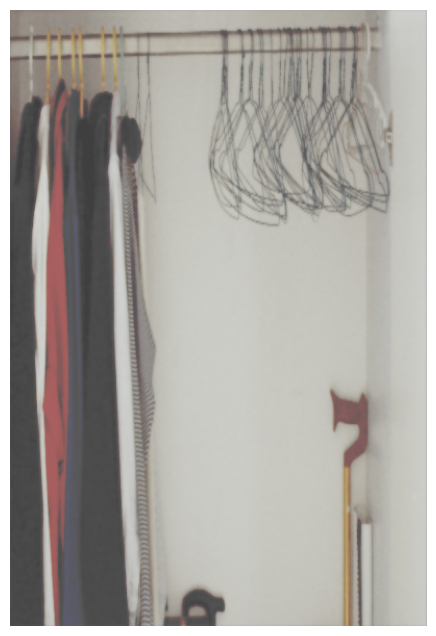

In [14]:
# 1. Load ảnh và chuyển đổi về tensor
image = Image.open("/kaggle/input/lol-dataset/lol_dataset/eval15/low/146.png").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((600, 400)),
    transforms.ToTensor(),  # Chuyển ảnh về tensor với giá trị từ 0 đến 1
])
input_image = transform(image).unsqueeze(0)  # Thêm chiều batch: (1, 3, H, W)
input_image = input_image.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo mô hình với cùng tham số như lúc training
model = LowlightEnhance(channel=64, kernel_size=3)
model.to(device)

# Tải trọng số mô hình
model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device, weights_only=True))

# 2. Đưa ảnh qua mô hình
model.eval()
with torch.no_grad():
    # Ở đây, chúng ta dùng decom_net để lấy R và L trực tiếp.
    # Nếu bạn muốn lấy đầu ra của toàn bộ mô hình LowlightEnhance (trả về R_low, I_low_3, S_low_zy),
    # bạn có thể gọi: R, I_low_3, _ = model(input_image)
    R, I_low_3 = model.decom_net(input_image)  # L có shape (1, 1, H, W)
    
# 3. In các giá trị thống kê của R và L
print("Giá trị R (phản xạ):")
print("  Mean: {:.4f}".format(R.mean().item()))
print("  Min: {:.4f}".format(R.min().item()))
print("  Max: {:.4f}".format(R.max().item()))

print("Giá trị I_low_3 (ánh sáng):")
print("  Mean: {:.4f}".format(I_low_3.mean().item()))
print("  Min: {:.4f}".format(I_low_3.min().item()))
print("  Max: {:.4f}".format(I_low_3.max().item()))

# 5. Kết hợp R và I_low_3 để tạo ảnh kết quả
enhanced_image = torch.clamp(R * I_low_3, 0, 1)  # Giữ giá trị trong khoảng [0, 1]

# 6. Chuyển ảnh kết quả về CPU và NumPy để hiển thị/lưu
enhanced_image_np = enhanced_image.squeeze(0).cpu().detach().numpy()  # (C, H, W)
enhanced_image_np = np.transpose(enhanced_image_np, (1, 2, 0))  # (H, W, C)
enhanced_image_np = (enhanced_image_np * 255).astype(np.uint8)  # Về [0, 255]

# 7. Lưu ảnh kết quả
enhanced_image_pil = Image.fromarray(enhanced_image_np)
enhanced_image_pil.save("enhanced_image8.png")
print("Đã lưu ảnh enhanced_image.png")

# 8. (Tùy chọn) Lưu ảnh R và I để kiểm tra trực quan
R_img = R.squeeze(0).cpu().detach().numpy()  # dự kiến: (3, H, W)
I_img = I_low_3.squeeze(0).cpu().detach().numpy()  # loại bỏ chiều batch; nếu I_low_3 ban đầu là (1, 1, 400, 600), kết quả sẽ là (1, 400, 600)

# Với R_img, nếu có 3 kênh, chuyển đổi sang (H, W, 3)
R_img = np.transpose(R_img, (1, 2, 0))
R_img = np.clip(R_img * 255.0, 0, 255).astype('uint8')

# Với I_img, nếu chỉ có 1 kênh, loại bỏ chiều kênh
I_img = I_img.squeeze(0)  # kết quả: (400, 600)
I_img = np.clip(I_img * 255.0, 0, 255).astype('uint8')

Image.fromarray(R_img).save("R_output.png")
Image.fromarray(I_img, mode="L").save("I_output.png")

print("Đã lưu ảnh R_output.png và I_output.png")

# Hiển thị ảnh
plt.figure(figsize=(6, 8))  # Thiết lập kích thước figure (tùy chọn)
plt.imshow(enhanced_image_pil)
plt.axis('off')            # Tắt hiển thị trục
plt.show()

In [15]:
num_params = sum(p.numel() for p in model.parameters())
print("Số lượng tham số của mô hình:", num_params)


Số lượng tham số của mô hình: 32655306


SSIM: 0.7640796899795532


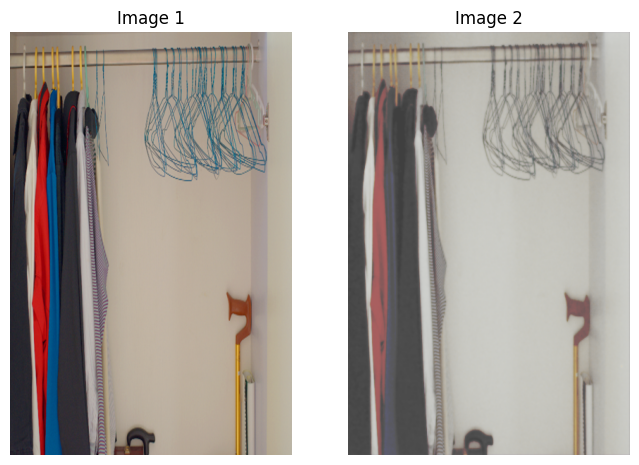

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def gaussian(window_size, sigma):
    """
    Tạo vector Gaussian 1D.
    :param window_size: Kích thước cửa sổ.
    :param sigma: Độ lệch chuẩn.
    :return: Tensor 1D có kích thước [window_size].
    """
    gauss = torch.tensor([np.exp(-((x - window_size//2)**2) / float(2 * sigma**2))
                            for x in range(window_size)], dtype=torch.float32)
    return gauss / gauss.sum()

def create_window(window_size, channel):
    """
    Tạo cửa sổ 2D từ vector Gaussian 1D cho SSIM.
    :param window_size: Kích thước cửa sổ (thường là 11).
    :param channel: Số kênh của ảnh (ví dụ 3 cho RGB).
    :return: Tensor có kích thước (channel, 1, window_size, window_size).
    """
    _1D_window = gaussian(window_size, sigma=1.5).unsqueeze(1)  # shape: (window_size, 1)
    _2D_window = _1D_window.mm(_1D_window.t()).float()           # shape: (window_size, window_size)
    _2D_window = _2D_window.unsqueeze(0).unsqueeze(0)             # shape: (1, 1, window_size, window_size)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    """
    Tính SSIM giữa hai ảnh.
    :param img1: Tensor ảnh thứ nhất, shape (N, C, H, W), giá trị trong [0, 1].
    :param img2: Tensor ảnh thứ hai, shape (N, C, H, W), giá trị trong [0, 1].
    :param window_size: Kích thước cửa sổ để tính SSIM.
    :param size_average: Nếu True, tính trung bình SSIM trên toàn bộ batch.
    :return: SSIM value.
    """
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel).to(img1.device)

    # Tính trung bình cục bộ của mỗi ảnh
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2

    # Tính phương sai và hiệp phương sai
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12   = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    # Các hằng số để tránh chia cho 0 (theo đề xuất của bài báo gốc)
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    # Công thức tính SSIM
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        # Trả về SSIM cho từng ảnh trong batch
        return ssim_map.mean(1).mean(1).mean(1)

# Ví dụ sử dụng:
if __name__ == "__main__":
    # Định nghĩa transform để chuyển ảnh sang tensor và resize (nếu cần)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Chuyển ảnh về tensor với giá trị [0,1]
    ])
    
    # Mở hai ảnh cần so sánh (đảm bảo chúng cùng kích thước)
    img1 = Image.open("/kaggle/input/lol-dataset/lol_dataset/eval15/high/146.png").convert("RGB")
    img2 = Image.open("/kaggle/working/enhanced_image8.png").convert("RGB")
    
    # Nếu cần, resize ảnh để cùng kích thước
    img1 = img1.resize((400, 600))
    img2 = img2.resize((400, 600))
    
    # Chuyển ảnh về tensor
    tensor1 = transform(img1).unsqueeze(0)  # shape: (1, 3, H, W)
    tensor2 = transform(img2).unsqueeze(0)
    
    # Tính SSIM
    ssim_val = ssim(tensor1, tensor2)
    print("SSIM:", ssim_val.item())
    
    # Hiển thị ảnh nếu muốn
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Image 1")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Image 2")
    plt.axis("off")
    
    plt.show()